In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
import pickle
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
data = pd.read_csv(r'/mnt/store/spam-data/spam-or-not.csv', encoding='utf-8', sep=',', usecols=range(2))
data.head(n=10)

,label,data
0,spam,Cashback Receivedfrom Paytm12:54 PMAdded To Pa...
1,spam,Paytm <Request Accepted514.99The amount has be...
2,spam,Cashback Received from +100w cupipGiPay [ii
3,spam,Cashback Received from +100w cupipGiPay [ii
4,spam,/ 15000 [8 18 51016 701609-00 FR IR...
5,spam,dailyhunt14 [NeBY LOCOPLAY LIVE GAMES WITH1 CR...
6,spam,Cashback Received from +100w cupipGiPay [ii
7,spam,Cashback Received from +100w cupipGiPay [ii
8,spam,Cashback Received from +100w cupipGiPay [ii
9,spam,/ 15000 [8 18 51016 701609-00 FR IR...


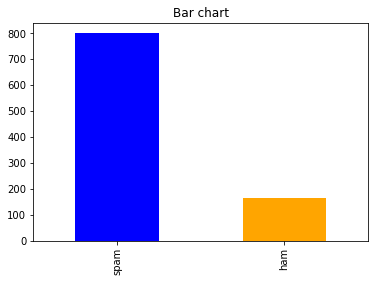

In [3]:
count_Class=pd.value_counts(data["label"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

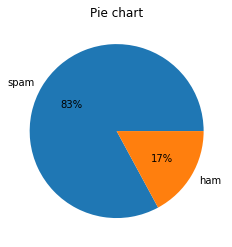

In [4]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

In [5]:
count1 = Counter(" ".join(data[data['label']=='ham']["data"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['label']=='spam']["data"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

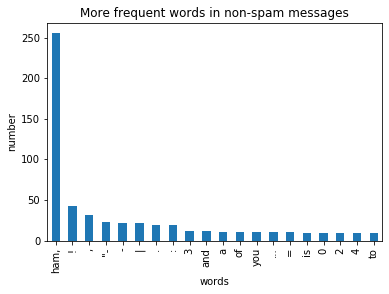

In [6]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

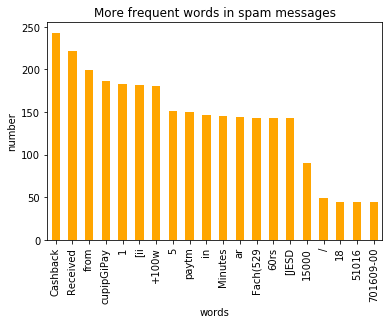

In [7]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [8]:


f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["data"])
np.shape(X)



(965, 1512)

In [9]:
data["label"]=data["label"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['label'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(646, 1512), (319, 1512)]


In [10]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 


In [11]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.888545,0.789969,0.919847,0.839721
1,0.11001,0.888545,0.786834,0.908397,0.843972
2,0.22001,0.890093,0.786834,0.912214,0.841549
3,0.33001,0.890093,0.783699,0.908397,0.840989
4,0.44001,0.890093,0.786834,0.912214,0.841549
5,0.55001,0.890093,0.786834,0.912214,0.841549
6,0.66001,0.877709,0.793103,0.923664,0.840278
7,0.77001,0.877709,0.793103,0.923664,0.840278
8,0.88001,0.877709,0.793103,0.923664,0.840278
9,0.99001,0.877709,0.796238,0.927481,0.840830


In [12]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             0.110010
Train Accuracy    0.888545
Test Accuracy     0.786834
Test Recall       0.908397
Test Precision    0.843972
Name: 1, dtype: float64

In [13]:
models[models['Test Precision']>=0.8].head(n=5)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.888545,0.789969,0.919847,0.839721
1,0.11001,0.888545,0.786834,0.908397,0.843972
2,0.22001,0.890093,0.786834,0.912214,0.841549
3,0.33001,0.890093,0.783699,0.908397,0.840989
4,0.44001,0.890093,0.786834,0.912214,0.841549


In [14]:
best_index = models[models['Test Precision']>=0.8]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             10.230010
Train Accuracy     0.845201
Test Accuracy      0.824451
Test Recall        1.000000
Test Precision     0.823899
Name: 93, dtype: float64

In [15]:


m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])



,Predicted 0,Predicted 1
Actual 0,1,56
Actual 1,0,262


In [16]:
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

In [17]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.876161,0.821317,1.000000,0.821317
1,600.0,0.890093,0.824451,1.000000,0.823899
2,700.0,0.890093,0.824451,1.000000,0.823899
3,800.0,0.890093,0.824451,1.000000,0.823899
4,900.0,0.890093,0.824451,1.000000,0.823899
5,1000.0,0.890093,0.824451,1.000000,0.823899
6,1100.0,0.890093,0.824451,1.000000,0.823899
7,1200.0,0.890093,0.821317,0.996183,0.823344
8,1300.0,0.890093,0.824451,1.000000,0.823899
9,1400.0,0.890093,0.824451,1.000000,0.823899


In [18]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

C                 600.000000
Train Accuracy      0.890093
Test Accuracy       0.824451
Test Recall         1.000000
Test Precision      0.823899
Name: 1, dtype: float64

In [19]:
models[models['Test Precision']>=0.8].head(n=5)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.876161,0.821317,1.0,0.821317
1,600.0,0.890093,0.824451,1.0,0.823899
2,700.0,0.890093,0.824451,1.0,0.823899
3,800.0,0.890093,0.824451,1.0,0.823899
4,900.0,0.890093,0.824451,1.0,0.823899


In [20]:


best_index = models[models['Test Precision']>=0.8]['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
models.iloc[best_index, :]



C                 600.000000
Train Accuracy      0.890093
Test Accuracy       0.824451
Test Recall         1.000000
Test Precision      0.823899
Name: 1, dtype: float64


Confusion matrix with support vector machine classifier.

In [21]:


m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])



,Predicted 0,Predicted 1
Actual 0,1,56
Actual 1,0,262


In [22]:
svc.predict(X_test)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
filename = 'models/text_model.save'


In [24]:
pickle.dump(svc, open(filename, 'wb'))

In [25]:
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
X.